# Forecast with naive approaches

## Introduction

In this notebook, I start forecasting with the most simple of time-series methods, which I'm calling "naive" approaches.

Specifically, I forecast, inspect and score forecasts for the two cities--San Juan and Iquitos.  

I use three simple methods:

* an average method
* a naive method, and 
* a seasonal naive method.

And, I inspect the residuals of the most successful methods.

I put my comments at the end of the notebook.

## Set up

In [1]:
# Eliminate some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot

import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.gridspec as gridspec

# Need converters for matplotlib to use dates in time plot
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
# Set some Seaborn defaults
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('muted')

In [4]:
import my_func

## Load data

In [5]:
test_sj = pd.read_pickle('../sb_cap2_nb-99_data/prep_test_sj.pickle')
train_sj = pd.read_pickle('../sb_cap2_nb-99_data/prep_train_sj.pickle')
test_iq = pd.read_pickle('../sb_cap2_nb-99_data/prep_test_iq.pickle')
train_iq = pd.read_pickle('../sb_cap2_nb-99_data/prep_train_iq.pickle')

score_df = pd.read_pickle('../sb_cap2_nb-99_data/scores_after_nbk_4.pickle')

## Define functions

In [6]:
def forecast_test_avg(df_test, df_train):
    """Add an average forecast to a test set"""
    
    test_avg = df_test.copy()
    test_avg_forcast = df_train['total_cases'].mean()
    test_avg['y_test'] = test_avg_forcast
    test_avg.rename(columns={'total_cases' : 'X_test'}, inplace=True)
    return test_avg

In [7]:
def forecast_train_avg(df_train):
    """Add an 'average' forcast to a training set"""
    
    train_avg = df_train.copy()
    ls = [np.nan]
    for i in range(1, len(train_avg)):
        train_avg_forecast = train_avg['total_cases'].iloc[0:i].mean()
        ls.append(train_avg_forecast)
    train_avg['y_train'] = ls
    train_avg.rename(columns={'total_cases' : 'X_train'}, inplace=True)
    train_avg.drop(train_avg.index[0], inplace=True)
                   
    return train_avg

In [8]:
def graph_X_and_y(top, bottom, city):
    """Visualize orginal values and forecast values as split by test and train"""
    
    # Build a common data frame
    top_df = top.copy()
    top_df.columns = ['original', 'forecast']
    top_df['dataframe'] = 'train'
    
    bottom_df = bottom.copy()
    bottom_df.columns = ['original', 'forecast']
    bottom_df['dataframe'] = 'test'
    top_and_bottom_df = pd.concat([top_df, bottom_df], axis=0)
    
    # Reset the index to keep Seaborn happy
    top_and_bottom_df.reset_index(inplace=True)
    
    # Calc Y limits
    y_min = -25
    y_max = int(top_and_bottom_df['original'].max() * 1.2)

    # Graph the actual values  
    g = plt.figure(figsize=(9, 2), dpi=100)
    g = sns.lineplot(data=top_and_bottom_df, x='week_start_date', y='original', hue = 'dataframe')
    g = plt.ylim(y_min, y_max)
    g = plt.xlabel('Year')
    g = plt.ylabel('Cases per week')
    g = plt.title('Actual values in {}'.format(city))
    g = plt.legend(loc=2, prop={'size': 6})
    g = plt.box(on=None)
    g = plt.show()

      
    # Graph the forecast values  
    g = plt.figure(figsize=(9, 2), dpi=100)
    g = sns.lineplot(data=top_and_bottom_df, x='week_start_date', y='forecast', hue = 'dataframe')
    g = plt.ylim(y_min, y_max)    
    g = plt.xlabel('Year')
    g = plt.ylabel('Cases per week')
    g = plt.title('Forecast values in {}'.format(city))
    g = plt.legend(loc=2, prop={'size': 6})
    g = plt.box(on=None)
    g = plt.show()


In [9]:
def forecast_naive_test(test, train):
    """Add a naive forecast to a test data"""
    
    naive_test_forcast = train['total_cases'].iloc[-1]
    naive_test = test.copy()
    naive_test['y_test'] = naive_test_forcast
    naive_test.rename(columns={'total_cases' : 'X_test'}, inplace=True)
    naive_test.name = 'naive_test'
    
    return naive_test

In [10]:
def forecast_naive_train(df):
    """Add a naive forecast to the training data"""
    
    naive_train = df.copy()
    naive_train['y_train'] = naive_train['total_cases'].shift(periods=1)
    naive_train.rename(columns={'total_cases' : 'X_train'}, inplace=True)
    naive_train.drop(naive_train.index[0], inplace=True)
    naive_train.name = 'naive_train_df'
    return naive_train

In [11]:
def forecast_szn_naive_test(test, train):
    """Forecast using seasonal naive method on test data"""
    
    szn_naive_test = test.copy()
    carryover = train.iloc[-52:].copy()
    ls = []
    for i in range(len(szn_naive_test)):
        if i < 52:
            szn_forcast = carryover['total_cases'].iloc[i] # Get last period from training set
        if i >= 52:
            szn_forcast = szn_naive_test['total_cases'].iloc[i-52] # Get last period from test set
        ls.append(szn_forcast)
    szn_naive_test['y_test'] = ls
    szn_naive_test.rename(columns={'total_cases' : 'X_test'}, inplace=True)
    return szn_naive_test

In [12]:
def forecast_szn_naive_train(df):
    """Add a szn_naive forecast to the training data"""
    
    szn_naive_train = df.copy()
    szn_naive_train['y_train'] = szn_naive_train['total_cases'].shift(periods=52)
    szn_naive_train.rename(columns={'total_cases' : 'X_train'}, inplace=True)
    szn_naive_train.drop(szn_naive_train.index[:52], inplace=True)
    return szn_naive_train

In [13]:
def calc_residuals(forecast_df):
    """Calculate residuals from a test and training set (with very specific columns)"""

    residuals_df = forecast_df.copy()
    residuals_in_list = []
    for i in range(len(residuals_df)):
        residuals_single_calc = residuals_df.iloc[i, 0] - residuals_df.iloc[i, 1]
        residuals_in_list.append(residuals_single_calc)
    residuals_df['residual'] = residuals_in_list
    residuals_df.drop(['X_test', 'y_test'], axis=1, inplace=True)
    
    return residuals_df

In [14]:
def graph_residuals_lineplot(residual_df, model, city):
    """Graph residuals as a line plot"""
    
    # Clean up data
    residual_df_to_graph = residual_df.copy()
    residual_df_to_graph.reset_index(inplace=True)
    
    # Graph the forecast values  
    g = plt.figure(figsize=(9, 2), dpi=100)
    g = sns.lineplot(data=residual_df_to_graph, x='week_start_date', y='residual')
    g = plt.xlabel('Year')
    g = plt.ylabel('Residual')
    g = plt.title('Residuals from over time from {} - {}'.format(model, city))
    g = plt.show()
    
    return

In [15]:
def graph_residuals_distplot(residual_df, model, city):
    """Graph residuals as distplot"""
    
    g = plt.figure(figsize=(9, 3), dpi=100)
    g = sns.distplot(residual_df['residual'], kde=True)
    g = plt.xlabel('Cases per week')
    g = plt.ylabel('Count of weeks')
    g = plt.title('Histogram and KDE of residuals from {} - {}'.format(model, city))
    g = plt.show()
    
    return

In [16]:
def graph_residuals_qqplot(residual_df, model, city):
    """Graph residuals as Q-Q Plot"""
    
    residuals = np.array(residual_df['residual'])
    g = qqplot(residual_df, line='r')
    g = plt.title('Q-Q plot of residuals for {} - {}'.format(model, city))
    g = plt.show()
    
    return

In [17]:
def graph_residuals_ACF(residual_df, model, city):
    """Graph residuals as ACF"""
    
    # Graph acf
    g = plot_acf(residual_df, lags=52)
    g = plt.xlabel('Lags')
    g = plt.ylabel('Correlation')
    g = plt.title('Autocorrelation of residuals for {} with 95% confidence intervals - {}'.format(model, city))
    g = plt.show()  
    
    return

In [18]:
def calc_residuals_acf(residual_df, model, city):
    """ Use statmodels' adfuller() to calc an ADF test"""
    
    df = residual_df
    
    # Extact the total_cases as a series
    df_cases = df['residual'].copy().to_numpy()
    
    # Calc test statistics
    results = adfuller(df_cases, maxlag=52, autolag=None) # Set lags to 52
    
    # Print results
    print('Here are the restuls of ADF testing on resdiuals from {} - {}'.format(model, city))
    print('')
    print('ADF test stat: \t{:>20.5f}'.format(results[0]))
    print('P value: \t{:>20.5f}'.format(results[1]))
    print('Lags used: \t{:>20.5f}'.format(results[2]))
    print('Observations: \t{:>20.5f}'.format(results[3]))
    print('Critical value at 1%: \t{:>12.5f}'.format(results[4].get('1%')))
    
    return

## Forecast with average method - San Juan

Here, the forecasts of future values are equal to the mean of all historical data. 

In [19]:
test_sj_avg_df = forecast_test_avg(test_sj, train_sj)

In [20]:
my_func.score('naive', 1, 'average method', 'san juan', 'test', 'none', 
              test_sj_avg_df['X_test'], test_sj_avg_df['y_test'], score_df)

In [21]:
train_sj_avg_df = forecast_train_avg(train_sj)

In [22]:
my_func.score('naive', 1, 'average method', 'san juan', 'train', 'none', 
              train_sj_avg_df['X_train'], train_sj_avg_df['y_train'], score_df)

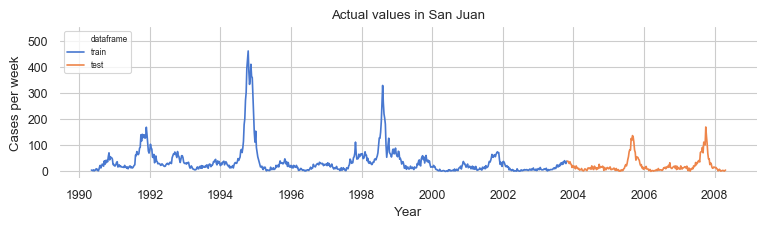

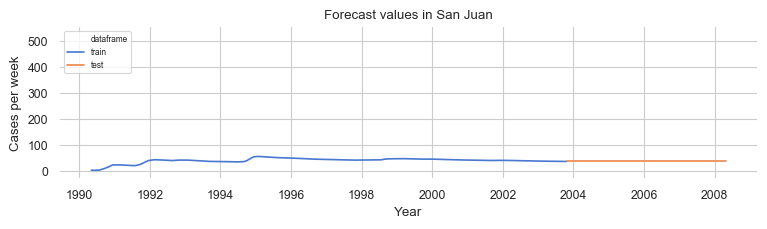

In [23]:
graph_X_and_y(train_sj_avg_df, test_sj_avg_df, 'San Juan')

In [24]:
score_df.tail(2)

,approach,variation,summary,city,data,transform,rmse,mae
0,naive,1,average method,san juan,test,none,32.393166,28.027285
1,naive,1,average method,san juan,train,none,56.612447,33.000524


In [25]:
test_avg_forcast = train_sj['total_cases'].mean()
print('The forecast value is {}'.format(test_avg_forcast))

The forecast value is 38.00854700854701


## Forecast with naive method - San Juan

Here, the forecast is the last observed value.

In [26]:
naive_sj_test_df = forecast_naive_test(test_sj, train_sj)

In [27]:
my_func.score('naive', 2, 'naive method', 'san juan', 'test', 'none', 
              naive_sj_test_df['X_test'], naive_sj_test_df['y_test'], score_df)

In [28]:
naive_sj_train_df = forecast_naive_train(train_sj)

In [29]:
my_func.score('naive', 2, 'naive method', 'san juan', 'train', 'none', 
              naive_sj_train_df['X_train'], naive_sj_train_df['y_train'], score_df)

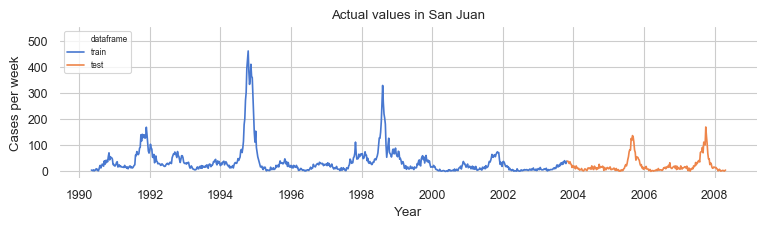

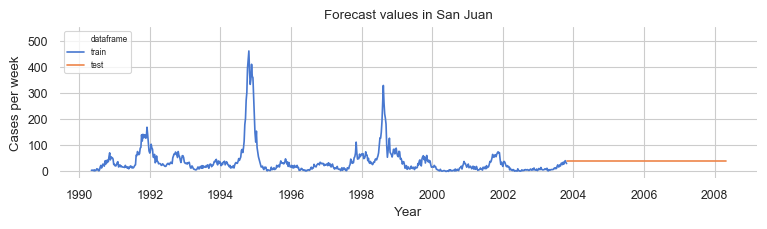

In [30]:
graph_X_and_y(naive_sj_train_df, naive_sj_test_df, 'San Juan')

In [31]:
score_df.tail(2)

,approach,variation,summary,city,data,transform,rmse,mae
2,naive,2,naive method,san juan,test,none,32.873430,28.713675
3,naive,2,naive method,san juan,train,none,14.527214,8.495007


In [32]:
naive_test_forcast = train_sj['total_cases'].iloc[-1]
print('The forecast value is {}'.format(naive_test_forcast))

The forecast value is 39


## Forecast with seasonal naive method - San Juan

Here, the forecast is the last observed value from the same season of the year (e.g., the same week of the previous year).

In [33]:
szn_naive_sj_test_df = forecast_szn_naive_test(test_sj, train_sj)

In [34]:
my_func.score('naive', 3, 'seasonal naive method', 'san juan', 'test', 'none', 
              szn_naive_sj_test_df['X_test'], szn_naive_sj_test_df['y_test'], score_df)

In [35]:
szn_naive_sj_train_df = forecast_szn_naive_train(train_sj)

In [36]:
my_func.score('naive', 3, 'seasonal naive method', 'san juan', 'train', 'none', 
              szn_naive_sj_train_df['X_train'], szn_naive_sj_train_df['y_train'], score_df)

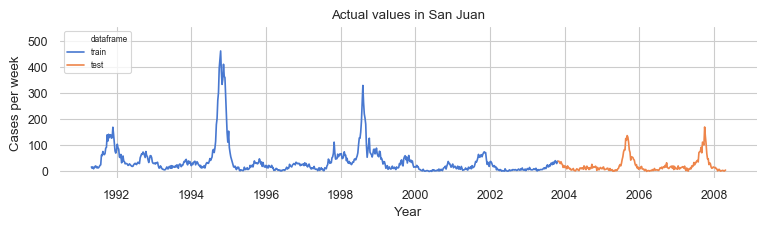

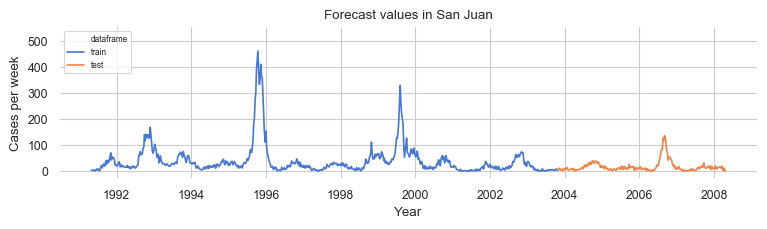

In [37]:
graph_X_and_y(szn_naive_sj_train_df, szn_naive_sj_test_df, 'San Juan')

In [38]:
score_df.tail(2)

,approach,variation,summary,city,data,transform,rmse,mae
4,naive,3,seasonal naive method,san juan,test,none,35.954565,21.337607
5,naive,3,seasonal naive method,san juan,train,none,81.504167,42.003077


## Review all models - San Juan

In [39]:
score_df[score_df['city'] == 'san juan'].sort_values(by=['data', 'mae'])

,approach,variation,summary,city,data,transform,rmse,mae
4,naive,3,seasonal naive method,san juan,test,none,35.954565,21.337607
0,naive,1,average method,san juan,test,none,32.393166,28.027285
2,naive,2,naive method,san juan,test,none,32.873430,28.713675
3,naive,2,naive method,san juan,train,none,14.527214,8.495007
1,naive,1,average method,san juan,train,none,56.612447,33.000524
5,naive,3,seasonal naive method,san juan,train,none,81.504167,42.003077


## Inspect residuals from best model - San Juan

In [40]:
szn_naive_sj_test_residuals = calc_residuals(szn_naive_sj_test_df)

In [41]:
szn_naive_sj_test_residuals.describe()

,residual
count,234.000000
mean,4.858974
std,35.701093
min,-122.000000
25%,-7.000000
50%,1.000000
75%,12.000000
max,155.000000


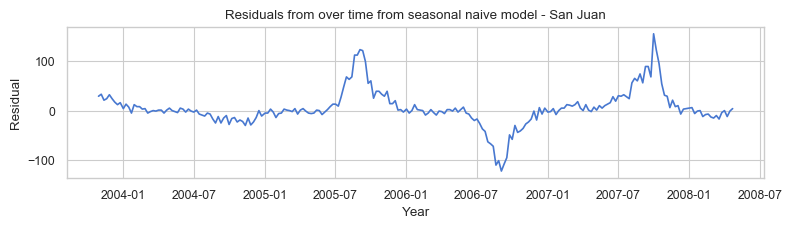

In [42]:
graph_residuals_lineplot(szn_naive_sj_test_residuals, 'seasonal naive model', 'San Juan')

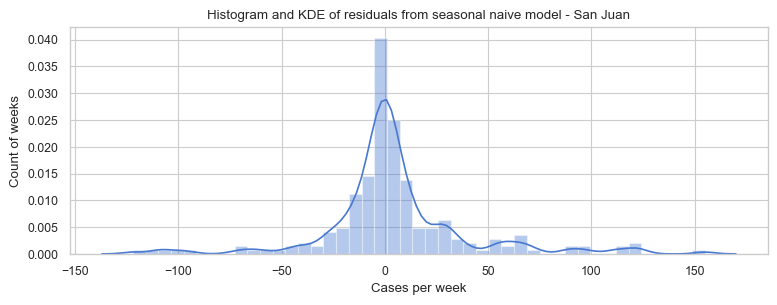

In [43]:
graph_residuals_distplot(szn_naive_sj_test_residuals, 'seasonal naive model', 'San Juan')

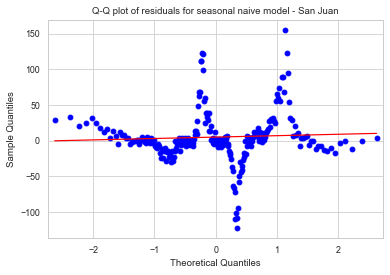

In [44]:
graph_residuals_qqplot(szn_naive_sj_test_residuals, 'seasonal naive model', 'San Juan')

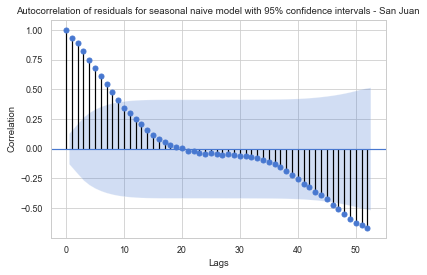

In [45]:
graph_residuals_ACF(szn_naive_sj_test_residuals, 'seasonal naive model', 'San Juan')

In [46]:
calc_residuals_acf(szn_naive_sj_test_residuals, 'seasonal naive model', 'San Juan')

Here are the restuls of ADF testing on resdiuals from seasonal naive model - San Juan

ADF test stat: 	            -3.59205
P value: 	             0.00591
Lags used: 	            52.00000
Observations: 	           181.00000
Critical value at 1%: 	    -3.46700


## Forecast with average method - Iquitos

In [47]:
test_iq_avg_df = forecast_test_avg(test_iq, train_iq)

In [48]:
my_func.score('naive', 4, 'average method', 'iquitos', 'test', 'none', 
              test_iq_avg_df['X_test'], test_iq_avg_df['y_test'], score_df)

In [49]:
train_iq_avg_df = forecast_train_avg(train_iq)

In [50]:
my_func.score('naive', 4, 'average method', 'iquitos', 'train', 'none', 
              train_iq_avg_df['X_train'], train_iq_avg_df['y_train'], score_df)

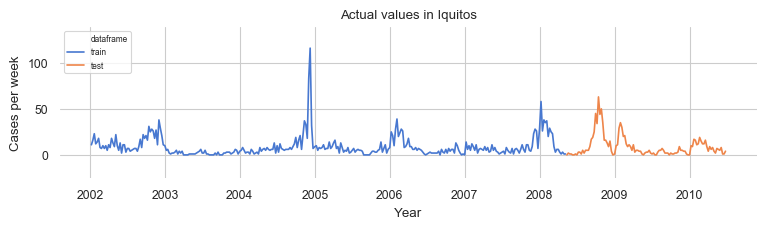

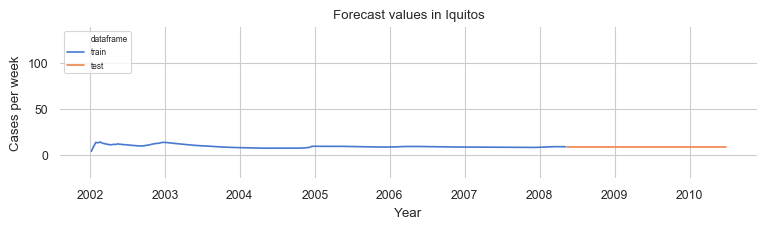

In [51]:
graph_X_and_y(train_iq_avg_df, test_iq_avg_df, 'Iquitos')

In [52]:
score_df.tail(2)

,approach,variation,summary,city,data,transform,rmse,mae
6,naive,4,average method,iquitos,test,none,11.261033,7.647914
7,naive,4,average method,iquitos,train,none,11.219506,6.831527


In [53]:
test_avg_forcast = train_iq['total_cases'].mean()
print('The forecast value is {}'.format(test_avg_forcast))

The forecast value is 8.824773413897281


## Forecast with naive method - Iquitos

In [54]:
naive_iq_test_df = forecast_naive_test(test_iq, train_iq)

In [55]:
my_func.score('naive', 5, 'naive method', 'iquitos', 'test', 'none', 
              naive_iq_test_df['X_test'], naive_iq_test_df['y_test'], score_df)

In [56]:
naive_iq_train_df = forecast_naive_train(train_iq)

In [57]:
my_func.score('naive', 5, 'naive method', 'iquitos', 'train', 'none', 
              naive_iq_train_df['X_train'], naive_iq_train_df['y_train'], score_df)

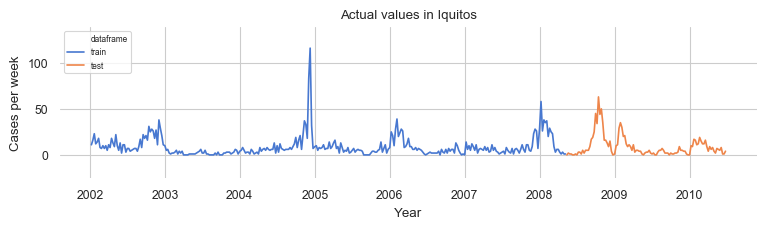

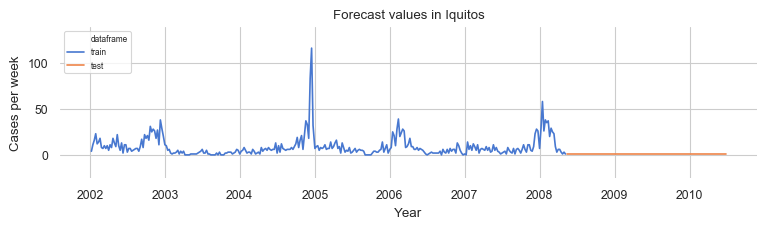

In [58]:
graph_X_and_y(naive_iq_train_df, naive_iq_test_df, 'Iquitos')

In [59]:
score_df.tail(2)

,approach,variation,summary,city,data,transform,rmse,mae
8,naive,5,naive method,iquitos,test,none,13.791890,8.162162
9,naive,5,naive method,iquitos,train,none,8.913558,4.803030


In [60]:
naive_test_forcast = train_iq['total_cases'].iloc[-1]
print('The forecast value is {}'.format(naive_test_forcast))

The forecast value is 1


## Forecast with seasonal naive method - Iquitos

In [61]:
szn_naive_iq_test_df = forecast_szn_naive_test(test_iq, train_iq)

In [62]:
my_func.score('naive', 6, 'seasonal naive method', 'iquitos', 'test', 'none', 
              szn_naive_iq_test_df['X_test'], szn_naive_iq_test_df['y_test'], score_df)

In [63]:
szn_naive_iq_train_df = forecast_szn_naive_train(train_iq)

In [64]:
my_func.score('naive', 6, 'seasonal naive method', 'iquitos', 'train', 'none', 
              szn_naive_iq_train_df['X_train'], szn_naive_iq_train_df['y_train'], score_df)

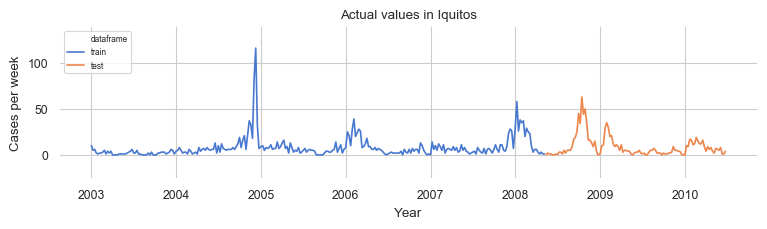

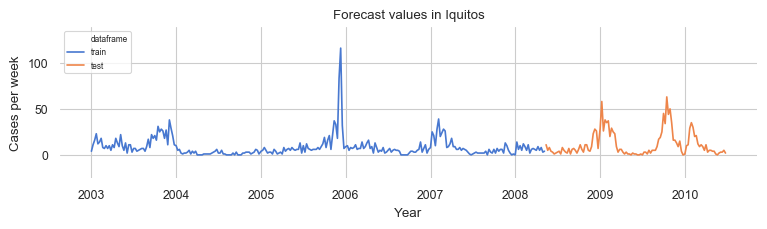

In [65]:
graph_X_and_y(szn_naive_iq_train_df, szn_naive_iq_test_df, 'Iquitos')

In [66]:
score_df.tail(2)

,approach,variation,summary,city,data,transform,rmse,mae
10,naive,6,seasonal naive method,iquitos,test,none,16.476847,9.918919
11,naive,6,seasonal naive method,iquitos,train,none,16.092809,9.372760


## Review all scores - Iquitos

In [67]:
score_df[score_df['city'] == 'iquitos'].sort_values(by=['data', 'mae'])

,approach,variation,summary,city,data,transform,rmse,mae
6,naive,4,average method,iquitos,test,none,11.261033,7.647914
8,naive,5,naive method,iquitos,test,none,13.791890,8.162162
10,naive,6,seasonal naive method,iquitos,test,none,16.476847,9.918919
9,naive,5,naive method,iquitos,train,none,8.913558,4.803030
7,naive,4,average method,iquitos,train,none,11.219506,6.831527
11,naive,6,seasonal naive method,iquitos,train,none,16.092809,9.372760


## Analyze residuals from best model - Iquitos

In [68]:
test_iq_avg_df_residuals = calc_residuals(test_iq_avg_df)

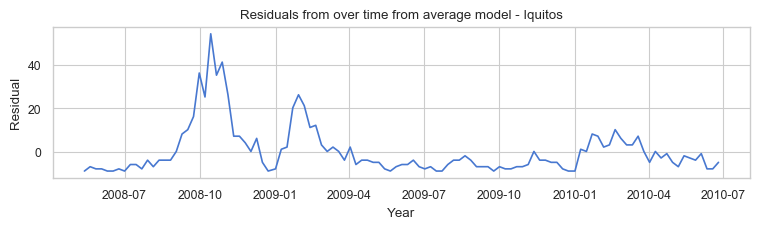

In [69]:
graph_residuals_lineplot(test_iq_avg_df_residuals, 'average model', 'Iquitos')

In [70]:
test_iq_avg_df_residuals.describe()

,residual
count,111.000000
mean,0.139191
std,11.311240
min,-8.824773
25%,-6.824773
50%,-3.824773
75%,2.175227
max,54.175227


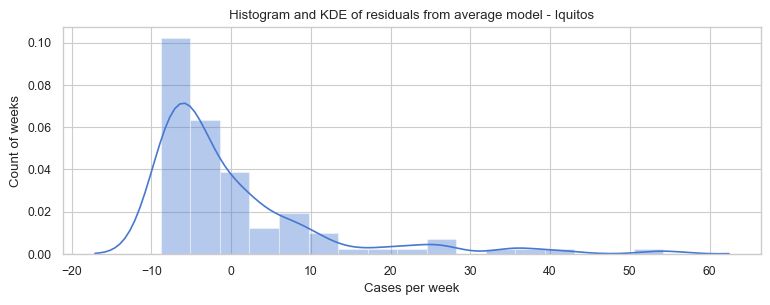

In [71]:
graph_residuals_distplot(test_iq_avg_df_residuals, 'average model', 'Iquitos')

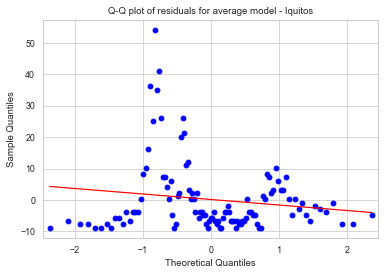

In [72]:
graph_residuals_qqplot(test_iq_avg_df_residuals, 'average model', 'Iquitos')

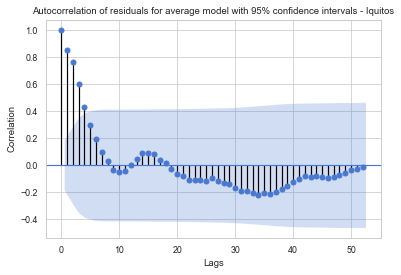

In [73]:
graph_residuals_ACF(test_iq_avg_df_residuals, 'average model', 'Iquitos')

In [74]:
calc_residuals_acf(test_iq_avg_df_residuals, 'average model', 'Iquitos')

Here are the restuls of ADF testing on resdiuals from average model - Iquitos

ADF test stat: 	            -1.51077
P value: 	             0.52818
Lags used: 	            52.00000
Observations: 	            58.00000
Critical value at 1%: 	    -3.54849


## Summarize scores from all simple methods

In [75]:
score_df.sort_values(by=['data', 'mae'], ascending=True).sort_values(by=['city'], ascending=False)

,approach,variation,summary,city,data,transform,rmse,mae
4,naive,3,seasonal naive method,san juan,test,none,35.954565,21.337607
0,naive,1,average method,san juan,test,none,32.393166,28.027285
2,naive,2,naive method,san juan,test,none,32.873430,28.713675
3,naive,2,naive method,san juan,train,none,14.527214,8.495007
1,naive,1,average method,san juan,train,none,56.612447,33.000524
5,naive,3,seasonal naive method,san juan,train,none,81.504167,42.003077
6,naive,4,average method,iquitos,test,none,11.261033,7.647914
8,naive,5,naive method,iquitos,test,none,13.791890,8.162162
10,naive,6,seasonal naive method,iquitos,test,none,16.476847,9.918919
9,naive,5,naive method,iquitos,train,none,8.913558,4.803030


## Save scores

In [76]:
score_df.to_pickle('../sb_cap2_nb-99_data/scores_after_nbk_5.pickle')

## Commentary

I explicitly frame this forecast problem as a time-series problem.  This is because:  
    
* The data is organized as a series of weekly observations--a temporal series.
* The autocorrelation--the direct link between the forecast variables' past, present and future values--is a key feature of both the domain (e.g., infections last week drive infections this week) and of the data (e.g., directly observable autocorrelation in the data).
* I want to learn more about the tools and techniques of time series.

To start, I use three of the simplest time-series forecast methods.  I forecast and score across a single 75/25 train/test split, which is visualized in figure X.  

I use the best of these forecasts as my performance baseline.  

These simple forecast methods are:

* Average method, where future values are forecast as the mean of all historical data, 
* Naive method, where future values are forecast as the last observed value, and
* Seasonal naive method, where future values are forecast as last season's observed value (e.g., the weekly value from 52 weeks prior).

### Forecasting with simple methods

**Evaluating results for San Juan**

* The seasonal naive method applied to the test data has the lowest MAE. I focus on MAE because it is frequently used to evaluate time series and it also is used to score this particular data competition. 
* The seasonal naive method's RMSE is higher than its MAE, which is expected and reflects RMSE's weight of the variance in the data. 
* Interestingly, the seasonal naive method applied to the training data has worse scores. Presumably, this is because the training data had has large "spikes" which, when shifted forward a year, mean large forecast errors.
* The other two methods-average and naive--have very similar scores on the test data. Mathematically, this is because both forecasts are a single value over the entire test period and both values--38 for the average method and 39 for the naive method--are very close. The likelihood of such similarity depends on how similarly distributed the two data sets are, I presume.
* I use the seasonal average method as my baseline for San Juan.
* To better understand how well this method is performing, I further examine the method's forecast error. Graphically, I do not see any trend or seasonality in the forecast error, which is good. The mean forecast error is not zero, which suggests this method has some positive bias--a bad thing. The distribution of the forecast error is somewhat, but not too, normal, which might suggest that our assumptions might be off. The Q-Q plot confirms that the forecast errors are not normal and highlights the "spikes" in our errors. The ACF shows autocorrelation in the first 8 lag periods. All in all, these problems with the forecast error indicate that our method can be further improved.

**Evaluating scores for Iquitos**

* The average and naive methods on Iquitos's test data have similar scores, like they do for San Juan. The average method has a slightly lower MAE. For both methods, the RMSE is higher than MAE, given the variance driven by the "spikes" in cases.
* The seasonal naive method for the test data has the lowest MAE and RMSE.
* I use the average method as the baseline for Iquitos.
* Examining the average method's forecast error indicates that there is an opportunity to improve. The forecast error's mean is not zero, indicating positive bias. The distribution is not too normal. The ACF indicates autocorrelation remains in the forecast error. An ADF test statistic is more than my critical value at 1%, which means I cannot accept the alternative (i.e., that forecast error is not stationary).